<p style="font-size: 42px;"><b>Recurrent Complex-Weighted Autoencoder</b></p>

Based on the paper <a href="https://www.proceedings.com/079017-4468.html">Recurrent Complex-Weighted Autoencoders for Unsupervised Object Discovery</a> featured in NeurIPS 2024<br>
Annotated by N. Smith, J. Kim, and S. Boinpally

The original paper was authored by:

<b>Anand Gopalakrishnan:</b><br> 
The Swiss AI Lab, IDSIA, USI & SUPSI, Lugano, Switzerland

<b>Aleksandar Stanic, Michael Curtis Mozer:</b><br>
Google DeepMind

<b>Jürgen Schmidhuber:</b><br>
The Swiss AI Lab, IDSIA, USI & SUPSI, Lugano, Switzerland<br>
AI Initiative, KAUST, Thuwal, Saudi Arabia

<br><br><br>
<p style="font-size: 24px;"><b>Background</b></p>
The authors' recurrent complex-weighted autoencoder model SynCx was developed to tackle the binding problem using unsupervised learning. The binding problem is a domain of object-centric learning wherein the goal is to associate input values amongst themselves and can be thought of as being similar to clustering. The goal is to group input values which belong to the same object in the environment together in a representation. Consider the still-life photograph in <b>figure 1</b>.

<br><br>
<center>
<img src="https://i.imgur.com/cLyy2bz.jpeg" style="display:block; margin:auto"/>
<br>
<b>Figure 1</b> Image source: <a href="https://weedit.photos/lighting-for-still-life-photography/">https://weedit.photos/lighting-for-still-life-photography/</a><br><br></div></center>
<br><br>

A computer receiving the raw version of this image does not know the pixels from the yellow pitcher belong to one object, the pixels from the blue bowl to another object, and so on. The goal of object-centric learning is to both separate inputs (pixels in this case) from one another if they do not belong to the same object while also grouping inputs which belong to the same object together. <b>Figure 2</b> shows one possible mask an object-centric model could produce as output from the still-life in <b>figure 1</b>. Extraneous information like texture and shadowing have been stripped away with the output only indicating what object each pixel is associated with - table, pitcher, bowl, each fruit, and the background. This example would be a perfect or near-perfect output.

<br><br>
<center>
<img src="https://i.imgur.com/iZ4u38k.jpeg" style="display:block; margin:auto"/>
<br>
<b>Figure 2</b> <br><br></div></center>
<br><br>

<b>Figure 3</b> shows a less-than-perfect output with some of the pixels having been misassigned to the wrong objects. Those familiar with semantic segmentation may recognize the output as resembling both the masks and output from semantic segmentation models. Though similar in appearance, the model proposed by the authors' is entirely unsupervised in its training process. 

<br><br>
<center>
<img src="https://i.imgur.com/Xri2qBc.jpeg" style="display:block; margin:auto"/>
<br>
<b>Figure 3</b> <br><br></div></center>
<br><br>

The recurrent complex-weighted autoencoder model processes input and produces object bindings entirely using complex numbers. The primary innovation of the recurrent complex-weighted autoencoder is that all operations use complex numbers only and that it does not use gating mechanisms to implement binding. It is a synchrony-based model which differed from the predominant paradigm in object-centric learning, namely slot-based models. Slot-based models maintain latent activation vectors - slots - which encode the features of objects, one object per slot. Synchrony-based models like this one instead encode bindings based on the synchronization of features which are phases in this case. Prior work relied upon real-valued weights which meant it was not able to take full advantage of the representational power of complex numbers. Additionally, the gating mechanisms employed by prior work made assumptions which limited their generalizability. As the model works with complex numbers, what follows is a brief refresher or introduction to complex numbers:


Imaginary unit $i = \sqrt{-1}$<br><br>
Complex number $z$:<br>
Rectangular or Cartesian form: $x$ is the real component while $y$ is the imaginary component<br>
$z = x + iy$<br>
magnitude: $r = \sqrt{x^2 + y^2}$<br>
phase: $\phi = \tan^{-1}(\frac{y}{x})$<br><br> 
Polar form: phase $\phi$ is the angle between the real axis and the complex number vector<br>
$z = r(cos(\phi) + isin(\phi))$<br>
$z = re^{i\phi}$ because $e^{i\phi} = cos(\phi) + isin(\phi)$ using Euler's identity<br> 
$x = cos(\phi)$<br>
$y = sin(\phi)$<br>



The recurrent complex-weighted autoencoder encodes object bindings using the phase of complex numbers. Each pixel of the input images is assigned a phase and this phase tracks what object the pixel is bound to or associated with. Pixels belonging to the same object should have aligned phases. The model is recurrent because it is run on the same input some number of times, where the phase output from the prior iteration is used in the subsequent iteration. When input images are passed to the model, they are first converted to complex form using randomly initialized phases drawn from a Von Mises distribution with mean zero with concentration equal to one. The model is trained to reconstruct input images which are expressed as the magnitude of the output, though the phase output is the real objective. The model is trained using the average mean squared error over the magnitude output of all recurrent iterations or in other words, mean MSE. The phase output from the last iteration can then be used to recover object bindings. This is done by clustering the phases using K-Means clustering. Recovery of the bindings depends on having a sense of how many distinct objects are in the input, though the training process does not depend on this knowledge and is entirely unsupervised.<br><br>   


<br><br>
<p style="font-size: 24px;"><b>Model implementation</b></p><br>
<p style="font-size: 18px;"><b>Necessary imports and global context settings</b></p><br>
The following code imports all libraries needed for the remainder of the implementation and sets the seeds used during random number generation<br>

In [1]:
#import necessary libraries
import torch
from torch import nn
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time

# ============================================================
# Global setup
# ============================================================

#set device; in order to utilize GPU, please change "cpu" to "cuda"
using_device = "cpu"
device = torch.device(using_device)

#set numpy random number generator seed for reproducability
numpy_seed = 17
np.random.seed(numpy_seed)

#set pytorch random number generator seed for reproducability
torch_seed = 1
torch.manual_seed(torch_seed); None

#Ensure deterministic CUDA behavior
if using_device == "cuda":
    torch.cuda.manual_seed(torch_seed); None
    torch.cuda.manual_seed_all(torch_seed); None
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

<br><br>
<p style="font-size: 18px;"><b>Helper functions</b></p><br>
The following code defines various helper functions needed throughout the duration of the model implementation. The functions in their order of appearance in the code are:
<ul>
<li><b>to_cartesian():</b> This function converts polar output from the model to Cartesian output which is needed before clustering using K-Means. This function follows the methodology in the source paper and converts the magnitudes of all object pixels to unit magnitude and sets the magnitudes of all background pixels to zero.</li>
<li><b>angle():</b> This function numerically stablizes the phase components of model output. </li>
<li><b>cluster():</b> This function is used to cluster the output of the model. K-Means clustering is used to cluster prior to computing ARI score.</li>
<li><b>ari_score():</b> This function computes the average ARI score by calling <b>ari()</b> on each model output.</li>    
<li><b>convert_data():</b> This function converts raw images and their corresponding masks to tensors and normalizes the images.</li>
<li><b>visualize():</b> This function is used to visualize the model's output.</li>
<li><b>ari():</b> This function computes individual Adjusted Rand Indices (ARI) and is called by <b>ari_score()</b> to averages them.</li>
</ul>

In [2]:
# ============================================================
# Helper functions
# These functions are used for:
# - converting complex model outputs into cartesian vectors
# - clustering complex model outputs and computing ARI
# - visualization
# - preparing data format
# ============================================================

#convert polar output to cartesian form
#set all magnitudes to 1 for objects using mask; set all magnitudes
#to 0 for the background using mask
def to_cartesian(model_output,masks):
    masks = torch.squeeze(masks,1)
    magnitude = model_output.abs()
    phase = model_output.angle()

    # Stack magnitude=1 and phase channels
    magnitude_and_phase = torch.cat((torch.ones_like(phase)[:, None], phase[:, None]), axis=1)

     # Zero out background by using mask
    magnitude = 1. - (masks==0.).type(torch.float)[:, None]
    magnitude_and_phase = magnitude_and_phase * magnitude[:, None]

    # Convert polar → cartesian
    output = torch.zeros(magnitude_and_phase.shape)
    r = magnitude_and_phase[:, 0]
    phi = magnitude_and_phase[:, 1:]
    sin = 1
    for i in range(magnitude_and_phase.shape[1] - 1):
        output[:, i] = r * torch.cos(phi[:, i]) * sin
        sin = sin * torch.sin(phi[:, i])
    output[:, -1] = r * sin

    # Split real/imag components and reshape to image format
    real_output = output[:,0,:]
    imaginary_output = output[:,1,:]
    cartesian_output = torch.cat((real_output,imaginary_output),axis=1)
    cartesian_output = torch.moveaxis(cartesian_output,1,3)
    return cartesian_output

#(numerically) stabilize angle; uses same epsilon as default for Torch's Adam optimizer
#set all imaginary components out-of-range to epsilon
def angle(z, epsilon=1e-8):
    y = z.clone()
    y.imag[(z.imag<epsilon)&(z.imag>-1.0*epsilon)] = epsilon
    return y.angle()

#use K-means clustering on model output; requires knowing how many distinct objects are in the
#image; convert model output from polar to cartesian coordinates then cluster the imaginary components
def cluster(tensor,k,mask):
    imaginary = to_cartesian(tensor,mask).detach().cpu().numpy()
    imaginary_shaped = imaginary.reshape(imaginary.shape[0],imaginary.shape[-2]*imaginary.shape[-3],imaginary.shape[-1])
    clustered_images = []
    for image in imaginary_shaped:
        #KMeans on each image
        kmeans = KMeans(n_clusters=k,n_init=5).fit(image).labels_
        clustered_images.append(kmeans.reshape(imaginary.shape[-2],imaginary.shape[-3]))
    labelled_images = np.array(clustered_images)
    return labelled_images

#compute average ARI score
def ari_score(ground_truths,final_reconstructions,num_objects):
    total_ari = 0
    clustered_reconstructions = cluster(final_reconstructions,num_objects,ground_truths)
    for i in range(final_reconstructions.shape[0]):
        total_ari+=ari(clustered_reconstructions[i],ground_truths[i][0],num_objects)
    return total_ari/clustered_reconstructions.shape[0]

#convert data to tensors and normalize input data
def convert_data(all_images,all_masks):
    all_images = torch.tensor(all_images,dtype=torch.float64)/255.0
    all_images = torch.moveaxis(all_images,3,1)
    all_masks = torch.tensor(all_masks,dtype=torch.uint8)
    return all_images,all_masks

#visualization for demo
def visualize(image,clustering,reconstruction,ground_truth,penultimate_output):
    fig = plt.figure(figsize=(15, 3))

    col1 = fig.add_subplot(151)
    col1.axis("off")
    col1.set_title("Input image")
    col1.imshow(image)

    col2 = fig.add_subplot(152)
    col2.axis("off")
    col2.set_title("Ground truth")
    col2.imshow(ground_truth)

    col3 = fig.add_subplot(153)
    col3.axis("off")
    col3.set_title("Reconstruction")
    col3.imshow(reconstruction)

    #Polar plot to visualize distribution of complex phases
    col4 = fig.add_subplot(154,projection='polar')
    col4.set_title("Polar output")
    theta = penultimate_output.angle().cpu().numpy().flatten()
    r = penultimate_output.abs().cpu().numpy().flatten()
    col4.scatter(theta,r,c=theta,cmap='hsv')

    col5 = fig.add_subplot(155)
    col5.axis("off")
    col5.set_title("Clustered phases")
    col5.imshow(clustering)

    fig.tight_layout()
    plt.show()
    plt.clf()

#calculate adjusted rand index (ARI)
def ari(clustering,ground_truth,num_objects):
    contingencies =  np.zeros((num_objects, num_objects))
    for i in range(clustering.shape[0]):
        for j in range(clustering.shape[1]):
            contingencies[clustering[i][j]][int(ground_truth[i][j].item()-1)]+=1
    nij = np.sum([(val)/2*(val-1) for val in (contingencies)])
    ai = sum([(val)/2*(val-1) for val in np.sum(contingencies,axis=1)])
    bj = sum([(val)/2*(val-1) for val in np.sum(contingencies,axis=0)])
    total = sum([val for val in np.sum(contingencies,axis=1)])
    n = (total/2)*(total-1)
    numerator = nij-(ai*bj)/n
    denominator = (ai+bj)/2 -(ai*bj)/n
    return(numerator/denominator)

<br><br>
<p style="font-size: 18px;"><b>Dataset construction</b></p><br>

To evaluate the model’s capacity for unsupervised object binding, we generated our own synthetic dataset of simple geometric scenes. Each image contains exactly three objects: a circle, a square, and a triangle, each with randomized size, position, and color texture. The dataset enforces several forms of variability:
<ul>
<li>Shape variation: Each object’s size is randomly selected from three possible values.</li>
<li>Position variation: Objects are placed at random coordinates within a 35×35 frame.</li>
<li>Texture variation: Each object receives random per-pixel RGB perturbations to prevent trivial color-based segmentation.</li>
<li>Occlusion: Depth ordering is randomized among six permutations so objects can partially cover one another.</li>
</ul>
<br>
Together, these characteristics allow the dataset to mimic important qualities of real object-centric datasets such as Tetrominoes (no occlusion) and CLEVR (occasional significant occlusion). These latter two datasets were two of the three datasets used in the source paper.
<br><br>
Each sample consists of:
<ul>
<li>A 35×35 RGB image</li>
<li>A 35×35 mask labeling each pixel as background, circle, square, or triangle (4 total classes).</li>
</ul>
<br>
The following code is used to generate the synthetic dataset.

In [3]:
# ============================================================
# Dataset builder
# Generates a synthetic dataset of circles, squares, triangles
# with random size/position and randomized depth ordering.
# Used to evaluate whether the model can recover object identity.
# ============================================================

#draw circle
def circle(rgb_image,ground_truth,i,j,circle_image):
    if circle_image[i][j]==1.0:
        rgb_image[0,i,j]=255
        rgb_image[1,i,j]=np.random.randint(low=100, high=200)
        rgb_image[2,i,j]=np.random.randint(low=100, high=200)
        ground_truth[i][j]=1
    return rgb_image,ground_truth

#draw square
def square(rgb_image,ground_truth,i,j,square_parameters):
    square_size = square_parameters[0]
    square_upper_x = square_parameters[1]
    square_upper_y = square_parameters[2]
    if j>=square_upper_x and j<=square_upper_x+square_size:
        if i>=square_upper_y and i<=square_upper_y+square_size:
            rgb_image[0,i,j]=np.random.randint(low=100, high=200)
            rgb_image[1,i,j]=255
            rgb_image[2,i,j]=np.random.randint(low=100, high=200)
            ground_truth[i][j]=2

    return rgb_image,ground_truth

#draw triangle
def triangle(rgb_image,ground_truth,i,j,triangle_parameters):
    triangle_size = triangle_parameters[0]
    triangle_upper_x = triangle_parameters[1]
    triangle_upper_y = triangle_parameters[2]
    if j>=triangle_upper_x and j<=triangle_upper_x+triangle_size:
        if i>=triangle_upper_y and i<=triangle_upper_y+triangle_size:
            if j-triangle_upper_x<=i-triangle_upper_y:
                rgb_image[0,i,j]=np.random.randint(low=100, high=200)
                rgb_image[1,i,j]=np.random.randint(low=100, high=200)
                rgb_image[2,i,j]=255
                ground_truth[i][j]=3

    return rgb_image,ground_truth

#helper function used to handle depth permutations (e.g. square can go in front of circle or vice versa)
def return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters):
    for k in range(3):
        if ordering[k]=="c":
            rgb_image,ground_truth = circle(rgb_image,ground_truth,i,j,circle_image)
        if ordering[k]=="s":
            rgb_image,ground_truth = square(rgb_image,ground_truth,i,j,square_parameters)
        if ordering[k]=="t":
            rgb_image,ground_truth = triangle(rgb_image,ground_truth,i,j,triangle_parameters)
    return rgb_image,ground_truth

#main dataset generation loop
def generate_dataset(num_samples):

    sizes = [4,8,14]

    resolution = (35,35)

    images = []
    masks = []
    counter = 0
    while counter<num_samples:

        rgb_image = np.random.randint(low=0, high=25, size=(3,resolution[0],resolution[1]))
        circle_size = sizes[np.random.randint(0,3)]
        circle_mid_x = np.random.randint(circle_size-1,resolution[0]-circle_size-1)
        circle_mid_y = np.random.randint(circle_size-1,resolution[0]-circle_size-1)

        square_size = sizes[np.random.randint(0,3)]
        square_upper_x = np.random.randint(0,resolution[0]-square_size-1)
        square_upper_y = np.random.randint(0,resolution[0]-square_size-1)

        triangle_size = sizes[np.random.randint(0,3)]
        triangle_upper_x = np.random.randint(0,resolution[0]-triangle_size-1)
        triangle_upper_y = np.random.randint(0,resolution[0]-triangle_size-1)

        x, y = np.meshgrid(np.arange(resolution[0]), np.arange(resolution[1]))

        squared_distance = (x - circle_mid_x)**2 + (y - circle_mid_y)**2

        ground_truth = np.zeros(resolution,dtype=np.uint8)
        circle_mask = squared_distance <= (circle_size/2)**2

        circle_image=np.zeros(resolution)
        circle_image[circle_mask]=1.0
        permutation = np.random.randint(0,6)

        square_parameters = [square_size,square_upper_x,square_upper_y]
        triangle_parameters = [triangle_size,triangle_upper_x,triangle_upper_y]
        for i in range(resolution[0]):
            for j in range(resolution[1]):

                if permutation==0:
                    ordering = ["c","s","t"]
                    rgb_image,ground_truth = return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters)
                elif permutation==1:
                    ordering = ["c","t","s"]
                    rgb_image,ground_truth = return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters)
                elif permutation==2:
                    ordering = ["s","c","t"]
                    rgb_image,ground_truth = return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters)
                elif permutation==3:
                    ordering = ["s","t","c"]
                    rgb_image,ground_truth = return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters)
                elif permutation==4:
                    ordering = ["t","c","s"]
                    rgb_image,ground_truth = return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters)
                elif permutation==5:
                    ordering = ["t","s","c"]
                    rgb_image,ground_truth = return_shape(rgb_image,ground_truth,ordering,i,j,circle_image,square_parameters,triangle_parameters)

        if len(np.unique(ground_truth))==4:
            images.append(np.moveaxis(rgb_image,0,2))
            masks.append(ground_truth)
            counter+=1

    return np.array(images).astype(np.uint8),np.array(masks)

<br><br>
<p style="font-size: 18px;"><b>Dataset sample</b></p><br>

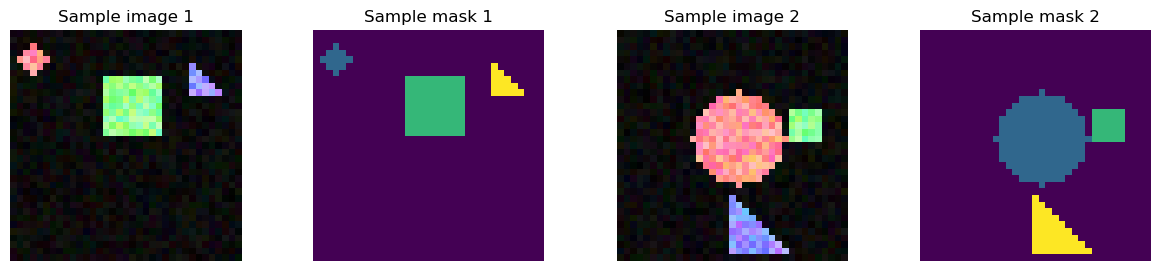

<Figure size 640x480 with 0 Axes>

In [4]:
#demonstrate dataset images
#display 2 images and their corresponding masks

num_samples = 2
sample_images,sample_masks = generate_dataset(num_samples)

fig = plt.figure(figsize=(15, 3))

col1 = fig.add_subplot(141)
col1.axis("off")
col1.set_title("Sample image 1")
col1.imshow(sample_images[0])

col2 = fig.add_subplot(142)
col2.axis("off")
col2.set_title("Sample mask 1")
col2.imshow(sample_masks[0])

col3 = fig.add_subplot(143)
col3.axis("off")
col3.set_title("Sample image 2")
col3.imshow(sample_images[1])

col3 = fig.add_subplot(144)
col3.axis("off")
col3.set_title("Sample mask 2")
col3.imshow(sample_masks[1])

plt.show()
plt.clf()

<br><br>
<p style="font-size: 20px;"><b>Model definition</b></p><br>
<br>
<p style="font-size: 18px;"><b>Layers</b></p><br>
The complex-weighted autoencoder requires using custom layers in order to work with complex numbers. The following is a brief description of how these layers function:
<ul>
<li><b>complex_convolution():</b> Performs 2D convolution on complex-valued input. Weight initialization for the magnitude component uniformly samples from a Rayleigh distribution with $\sigma = \frac{1}{fan-in}$ while sampling the phase component uniformly from [$-\pi$,$\pi$]. Magnitude biases are initialized uniformly from [$-\frac{1}{\sqrt{fan-in}}$,$\frac{1}{\sqrt{fan-in}}$] while phase biases are simply initialized to $0$. Note that fan-in is the number of input units to a particular layer. The forward method for complex_convolution() numerically stablizes the output from convolution and returns $\mu e^{i\phi}$ where $\mu$ is the magnitude component of the output and $\phi$ is the stablized phase component of the output.</li>
<li><b>complex_upsample():</b>Performs nearest-neighbors upsampling on the phase and magnitude components separately and combines them by returning $\mu e^{i\phi}$ similar to <b>complex_convolution()</b>.</li>
<li><b>modrelu():</b> The activation function used which adapts ReLU to work with complex numbers. It returns <b>ReLU</b>($\mu+$bias)$\odot e^{i\phi}$ where $\mu$ is the magnitude component of the input and $\phi$ is the phase component of the input.</li>
</ul>

In [5]:
# ============================================================
# Complex-valued CNN Layer Definitions
# These layers operate directly on complex tensors:
# - complex_convolution: complex Conv2d with magnitude/phase bias
# - complex_upsample: upsampling magnitude + phase separately
# - modrelu: activation applied to magnitude, preserves phase
# ============================================================


#class for custom convolution with complex numbers
class complex_convolution(nn.Module):
    """
    Complex-valued convolution block.
    Weight initialized in polar form.
    Output = (|conv| + mag_bias) * exp(i*(angle(conv) + phase_bias))
    """
    #initialize complex convolution layer
    def __init__(self,input_size,output_size,kernel,stride,padding,init_phase_min,init_phase_max):
        super().__init__()
        #initialize convolution parameters
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.input_size,self.output_size = input_size,output_size
        self.initial_phase_minimum = init_phase_min
        self.initial_phase_maximum = init_phase_max
        #initialize torch Conv2d
        self.convolution = nn.Conv2d(self.input_size,
                                     self.output_size,
                                     self.kernel,
                                     self.stride,
                                     padding,
                                     bias=False,
                                     dtype=torch.complex64)
        self.convolution.apply(self._initialize_weights)
        self.magnitude_bias = nn.Parameter(torch.empty((1,self.output_size,1,1)))
        self.phase_bias = nn.Parameter(torch.empty((1,self.output_size,1,1)))
        fan_in = self.input_size * self.kernel**2
        self.magnitude_bias,self.phase_bias = self._initialize_biases(fan_in,self.magnitude_bias,self.phase_bias)

    #initialize complex weights
    def _initialize_weights(self,module):
        magnitude = np.random.rayleigh(1/np.sqrt(np.prod(module.weight.shape[1:])), module.weight.shape)
        phase = np.random.uniform(self.initial_phase_minimum, self.initial_phase_maximum,module.weight.shape)
        with torch.no_grad():
            module.weight.real.copy_(torch.from_numpy(magnitude * np.cos(phase)))
            module.weight.imag.copy_(torch.from_numpy(magnitude * np.sin(phase)))
    #initialize complex biases
    def _initialize_biases(self,fan_in,magnitude_bias,phase_bias):
        #edit
        nn.init.uniform_(magnitude_bias, -1/np.sqrt(fan_in), 1/np.sqrt(fan_in))
        nn.init.constant_(phase_bias, val=0)
        return magnitude_bias,phase_bias
    #forward method for complex convolution
    def forward(self, x):
        complex_conv = self.convolution(x)
        magnitude_component = complex_conv.abs() + self.magnitude_bias
        #use numerically stable phase
        phase_component = angle(complex_conv) + self.phase_bias
        return magnitude_component * torch.exp(phase_component * 1j)

class complex_upsample(nn.Module):
    """Nearest-neighbor upsampling for magnitude & phase separately."""
    def __init__(self, size):
        super(complex_upsample, self).__init__()
        #edit
        self.upsample_magnitude = nn.UpsamplingNearest2d(size)
        self.upsample_phase = nn.UpsamplingNearest2d(size)

    def forward(self, x):
        magnitude_component = self.upsample_magnitude(x.abs())
        phase_component = self.upsample_phase(x.angle())
        return magnitude_component * torch.exp(phase_component * 1j)

class modrelu(nn.Module):
    """ModReLU activation used in complex-valued networks."""
    def __init__(self,hidden_dimensions):
        super().__init__()
        self.bias = nn.Parameter(torch.Tensor(1,hidden_dimensions,1,1))
        nn.init.constant_(self.bias, -0.1)
    def forward(self, x):
        return nn.functional.relu(x.abs() + self.bias) * (torch.exp(x.angle() * 1j))

<br>
<p style="font-size: 18px;"><b>Architecture</b></p><br>
The implementation follows the architecture from the source paper fairly closely though scales it down. The following table describes the architecture of the complex-weighted autoencoder:<br>

|          | Original implementation | Scaled down implementation |
|:--------|:--------:|:--------:|
|  <b>Encoder:</b>   |     |     |
|  <b>Encoder layer 1:</b> Input resolution: 35x35; output resolution: 17x17<ul><li>Complex convolution: kernel size: 3x3; stride: 2; input channels:</li><li>modReLU</li><li>Function: Spatially downsample complex input while increasing number of feature maps; apply nonlinear activation to complex output</li><uk>   |  input channels: 3<br>output channels: 64   |  input channels: 3<br>output channels: 32   |
|  <b>Encoder layer 2:</b> Input resolution: 17x17; output resolution: 8x8<ul><li>Complex convolution: kernel size: 3x3; stride: 2; input channels:</li><li>modReLU</li><li>Function: Spatially downsample complex input while increasing number of feature maps; apply nonlinear activation to complex output</li><uk>   |  input channels: 64<br>output channels: 128   |  input channels: 32<br>output channels: 64   |
|  <b>Encoder layer 3:</b> Input resolution: 8x8; output resolution: 3x3<ul><li>Complex convolution: kernel size: 3x3; stride: 2; input channels:</li><li>modReLU</li><li>Function: Spatially downsample complex input while preserving number of feature maps; apply nonlinear activation to complex output</li><uk>   |  input channels: 128<br>output channels: 128   |  input channels: 64<br>output channels: 64   |
|  <b>Decoder:</b>   |     |     |
|  <b>Decoder layer 1:</b> Input resolution: 3x3; output resolution: 8x8<ul><li>Nearest neighbors upsampling</li><li>Complex convolution: kernel size: 3x3; stride: 2; input channels:</li><li>modReLU</li><li>Function: Spatially upsample complex input while preserving number of feature maps; apply complex convolution preserving increased spatial resolution; apply nonlinear activation to complex output</li><uk>   |  input channels: 128<br>output channels: 128   |  input channels: 64<br>output channels: 64   |
|  <b>Decoder layer 2:</b> Input resolution: 8x8; output resolution: 17x17<ul><li>Nearest neighbors upsampling</li><li>Complex convolution: kernel size: 3x3; stride: 2; input channels:</li><li>modReLU</li><li>Function: Spatially upsample complex input while reducing number of feature maps; apply complex convolution preserving increased spatial resolution; apply nonlinear activation to complex output</li><uk>   |  input channels: 128<br>output channels: 64   |  input channels: 64<br>output channels: 32   |
|  <b>Decoder layer 3:</b> Input resolution: 17x17; output resolution: 35x35<ul><li>Nearest neighbors upsampling</li><li>Complex convolution: kernel size: 3x3; stride: 2; input channels:</li><li>modReLU</li><li>Function: Spatially upsample complex input while reducing number of feature maps; apply complex convolution preserving increased spatial resolution; apply nonlinear activation to complex output</li><uk>   |  input channels: 64<br>output channels: 3   |  input channels: 32<br>output channels: 3   |
|  <b>Output head:</b> Input resolution: 35x35; output resolution: 35x35<ul><li>Complex convolution: kernel size: 1x1; stride: 1</li><li>Function: Apply output complex convolution while preserving number of feature maps and spatial dimensions</li><uk>   |  input channels: 3<br>output channels: 3   |  input channels: 3<br>output channels: 3   |

The following code defines the model architecture:

In [6]:
# ==============================================================
# CAE Encoder–Decoder Architecture
# 3 downsampling encoder stages and 3 upsampling decoder stages.
#
# Each encoder stage uses:
# - a complex convolution
# - followed by modReLU
#
# Each decoder stage uses:
# - nearest neighbors upsampling
# - a complex convolution
# - followed by modReLU
#
# Encoder structure (example):
#   conv -> modrelu -> conv -> modrelu -> conv -> modrelu
#
# Decoder reconstructs input back symmetrically.
# Decoder structure (example):
#   upsample -> conv -> modrelu -> upsample -> conv -> modrelu
#
# ==============================================================


class cae_model(nn.Module):
    """
    Main encoder-decoder backbone.
    - Encoder: complex conv + modReLU
    - Decoder: complex upsample + complex conv + modReLU
    Uses fixed architecture defined by encoder/decoder_parameters.
    """
    def __init__(self,input_size,output_size,hidden_units,resolution,kernel,stride,init_phase_min,init_phase_max):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        self.kernel = kernel
        self.stride = stride
        self.resolution = resolution
        self.padding = (self.kernel-self.stride)//2
        self.init_phase_min=init_phase_min
        self.init_phase_max=init_phase_max

        # Encoder structure: (channels_in_multiplier, channels_out_multiplier)
        self.encoder_parameters = [[1,1],[1,2],[2,2]]

        self.encoder_blocks = nn.ModuleList()
        for j,k in self.encoder_parameters:
            input_dims = self.input_size if k==1 else self.output_size

            self.encoder_blocks.append(complex_convolution(j*self.hidden_units if k>1 else self.input_size,
                                                           k*self.hidden_units,
                                                           self.kernel,
                                                           self.stride,
                                                           "same" if stride==1 else "valid",
                                                           self.init_phase_min,
                                                           self.init_phase_max))
            self.encoder_blocks.append(modrelu(k*self.hidden_units))

        # Mirror decoder architecture
        self.decoder_parameters = [[i]+self.encoder_parameters[i] for i in range(3)][::-1]

        self.decoder_blocks = nn.ModuleList()

        for i,j,k in self.decoder_parameters:
            input_dims = self.input_size if k==1 else self.output_size
            self.decoder_blocks.append(complex_upsample(self.resolution[0]//self.stride**i))
            self.decoder_blocks.append(complex_convolution(k*self.hidden_units,
                                                           j*self.hidden_units if k>1 else self.input_size,
                                                           self.kernel,
                                                           1,
                                                           "same",
                                                           self.init_phase_min,
                                                           self.init_phase_max))
            self.decoder_blocks.append(modrelu(j*self.hidden_units if k>1 else self.input_size))
        if self.resolution[0] in [64,94]:
            self.decoder_blocks.append(complex_convolution(self.input_size,self.output_size,1,1,"same",self.init_phase_min,self.init_phase_max))
            self.decoder_blocks.append(modrelu(j*self.hidden_units if k>1 else self.input_size))
            
    def forward(self,x):
        """
        Run through encoder blocks then decoder blocks.
        Returns every intermediate activation (for visualization).
        """
        output = []
        for index, encoder_block in enumerate(self.encoder_blocks):
            x = encoder_block(x)
            output.append(x)
        for index, decoder_block in enumerate(self.decoder_blocks):
            x = decoder_block(x)
            output.append(x)
        return output

<br>
<p style="font-size: 18px;"><b>Model class</b></p><br>
The main model class initializes the architecture. It also converts raw image input to complex input. It does this by sampling phases randomly from a Von Mises distribution with $\mu = 0$ and concentration $= 1$. It returns : $\mu e^{i\phi}$ where $\mu$ is the raw input and $\phi$ is the sampled phases. The forward method works as follows:<br>
Forward:
<ul>
<li>Step 0: convert raw input to complex input</li>
<li>Do steps 1-5 n times:</li>
<li>Step 1: pass converted input to model</li>
<li>Step 2: pass model body output to model head</li>
<li>Step 3: Use model head phase output to reconvert raw input to complex input</li>
<li>Step 4: retain the model body outputs and model head outputs</li>
<li>Step 5: go to step 1</li>
<li>Step 6: convert all model head inputs to reconstucted images using output magnitude</li>
<li>Step 7: return all model body outputs image reconstructions</li>
</ul>
<br>

<b>Figure 4</b> below illustrates at a high-level how the model functions. 
<center>
<img src="https://i.imgur.com/RtP52DI.jpeg" style="display:block; margin:auto"/>
<b>Figure 4.</b> Note that the phase output only appears in the form shown above after K-Means clustering.</center><br><br>
The reuse of model outputs to reprocess the same inputs n times is what makes this a recurrent model. The model uses a loss function which computes the mean squared error over each of the n passes. This encourages pixel-wise fidelity in magnitude while allowing phase to adapt naturally as a binding mechanism. Consistent with the original paper, the phase is not included in the loss; it emerges from the dynamics of the reconstruction process. The loss is defined as:<br><br>
<center>
<b>L</b> $=\frac{1}{m}\sum_{j=1}^{m}\frac{1}{n}\sum_{i=1}^{n} ||\mu_{xj} - \mu_{zj}^{i}||^{2}$
</center>
<br><br>
m denotes the number of images, x denotes the raw input image, and z denotes the model reconstructions
<br>
It should be noted that when computing the loss, the raw input image is repeated n times for each of the n recurrent outputs.
<br>
The following code defines the main model class:

In [7]:
# ==================================================================================
# Main Recurrent Complex Autoencoder
# ----------------------------------------------------------------------------------
# - Runs CAE body for N iterations
# - Each iteration predicts a phase map
# - First phase map is randomly initialized
# - New complex input is constructed using the predicted phase from prior iteration
# - Final activations are used for clustering
# ==================================================================================

class complex_autoencoder(nn.Module):
    """
    Full model with recurrence:
      inputs -> (make complex) -> [CAE] -> output
      Phase of output is fed back into next iteration (z)
    """
    def __init__(self,img_resolution,input_size,kernel,stride,hidden_units,iterations,phase_init_min,phase_init_max):
        super(complex_autoencoder, self).__init__()
        self.resolution = img_resolution
        self.input_size = input_size
        self.kernel = kernel
        self.stride = stride
        self.output_size = self.input_size
        self.hidden_units = hidden_units
        self.iterations = iterations
        self.init_phase_min = phase_init_min
        self.init_phase_max = phase_init_max

        self.model_body = cae_model(self.input_size,
                                    self.output_size,
                                    self.hidden_units,
                                    self.resolution,
                                    self.kernel,
                                    self.stride,
                                    self.init_phase_min,
                                    self.init_phase_max)
        self.model_output = complex_convolution(self.input_size,self.output_size,1,1,"same",self.init_phase_min,self.init_phase_max)

    #randomly initialize phase map and use to convert input to complex input
    def _make_complex_input(self,input_features):
        von_mises_distribution = torch.distributions.von_mises.VonMises(loc=torch.tensor(0.),concentration=torch.tensor(1.))
        phase = von_mises_distribution.sample(input_features.shape).to(device)
        complex_input = input_features * torch.exp(phase * 1j)
        return complex_input.to(torch.complex64)

    def forward(self,inputs):
        """
        For n iterations:
          - Run encoder-decoder backbone
          - Produce head output
          - Re-inject phase back into input
        Returns:
          - all reconstructions (magnitudes)
          - intermediate complex outputs (for clustering)
        """
        outputs = torch.empty(0,dtype=torch.complex64).to(device)
        intermediate_outputs = torch.empty(0,dtype=torch.complex64).to(device)
        z = self._make_complex_input(inputs)
        for n in range(self.iterations):
            body_output = self.model_body(z)
            head_output = self.model_output(body_output[-1])
            outputs=torch.cat((outputs,torch.unsqueeze(head_output,0)),axis=0)
            intermediate_outputs=torch.cat((intermediate_outputs,torch.unsqueeze(body_output[-1],0)),axis=0)
            z = (inputs * torch.exp(head_output.angle() * 1j)).to(torch.complex64)
        outputs = torch.moveaxis(outputs,0,1)
        intermediate_outputs = torch.moveaxis(intermediate_outputs,0,1)
        all_reconstructions = outputs.abs().to(torch.float64)
        return all_reconstructions, intermediate_outputs

    #compute MSE over each of the n recurrent passes (mean MSE)
    def get_loss(self,reconstructions,inputs):
        inputs = torch.unsqueeze(inputs,1)
        #repeat input for each of the n passes
        inputs = inputs.repeat(1, reconstructions.shape[1], 1, 1, 1)
        loss = torch.nn.functional.mse_loss(reconstructions, inputs, reduction="mean")
        return loss

<br>
<p style="font-size: 18px;"><b>Generate dataset</b></p><br>

In [8]:
# ============================================================
# Dataset Loading & Splitting
# ------------------------------------------------------------
# - Generate synthetic dataset
# - Convert images/masks to tensors
# - Split into training / validation / test sets
# ============================================================


total_samples = 1550
all_images,all_masks = generate_dataset(total_samples)

#Convert and split
images, masks = convert_data(all_images,all_masks)
training_images,training_masks = images[:1000],masks[:1000]
validation_images,validation_masks = images[1000:1500],masks[1000:1500]
testing_images,testing_masks = images[1500:1550],masks[1500:1550]

#Merge masks with images for validation loader
validation_masks = torch.unsqueeze(validation_masks,axis=1)
testing_masks = torch.unsqueeze(testing_masks,axis=1)
validation_images = torch.cat((validation_images,validation_masks),axis=1)

<br>
<p style="font-size: 18px;"><b>Model training</b></p><br>
The training procedure for our scaled-down recurrent complex-weighted autoencoder closely follows the principles introduced in the SynCx model. This section describes (1) preprocessing and data splits, (2) the training objective and forward pass, and (3) the validation strategy including ARI-based early stopping. The overarching goal of training is to reconstruct the input magnitudes while allowing the model's complex phases to self-organize into object bindings without any supervision.<br><br>

We generated 1550 samples and used the following split:
<ul>
<li>Training: 1000 samples</li>
<li>Validation: 500 samples</li>
<li>Test: 50 samples</li>
</ul>

The validation set concatenates images and masks along the channel dimension to facilitate ARI computation during training.

<p style="font-size: 16px;">Training objective:</p>
As in the SynCx model, the network is not trained to predict object masks or phases directly. Instead, the autoencoder is trained only to reconstruct the magnitude of the input image. The complex phase is left entirely unsupervised; it is expected to self-organize into coherent synchrony groups that represent object bindings.<br><br>
For each minibatch:<br>
&emsp;1. The real input image is converted to a complex input by assigning a randomly sampled phase from a Von Mises distribution.<br>
&emsp;2. The model performs n recurrent iterations, each producing a reconstruction and a phase map.<br>
&emsp;3. In each iteration, the new complex input is created by combining the original magnitude with the predicted phase.<br>

<br>
<p style="font-size: 16px;">Training loop structure:</p>
Each training epoch consists of:<br><br>
1. <b>Forward Pass</b><br>
The model returns:
<ul>
<li>all_reconstructions: magnitude outputs for all recurrent iterations</li>
<li>intermediate_outputs: the final complex activations (used for clustering)</li>
</ul>
2. <b>Loss Computation and Backpropagation</b><br>
&emsp;Reconstruction loss is computed using the averaged magnitude MSE.<br>
&emsp;Gradients are backpropagated through the recurrent pathway.<br>
&emsp;Gradient clipping (clip_grad_norm_) is used for numerical stability.<br>
&emsp;The optimizer (Adam, lr = 0.0005, $\epsilon$ = 1e-8) performs an update step.<br>
<br>
Random seeds are fixed for NumPy and PyTorch to ensure determinism.
If running on CUDA, deterministic cuDNN behavior is enabled as well.
<br>
Both training and validation use infinite iterators (cycle()) so that evaluation timings are independent of dataset size and do not require epoch alignment.
<br><br>
<p style="font-size: 16px;">Validation and ARI-Based Early Stopping:</p>
While training is driven purely by magnitude MSE, performance is evaluated using the Adjusted Rand Index (ARI), which measures consistency between predicted phase clusters and the ground-truth object masks. This evaluation reflects the true purpose of the model—object binding via synchrony among phases.<br><br>

Every evaluation_trigger (10) training epochs:<br>
&emsp;1. A validation batch is drawn.<br>
&emsp;2. The model performs a full forward pass.<br>
&emsp;3. The validation loss is computed.<br>
&emsp;4. The phase output from the final iteration is clustered using K-Means.<br>
&emsp;5. ARI is computed between the cluster labels and the ground-truth mask.<br>
<br>
The model uses an ARI-based early stopping mechanism:

<ul>
<li>If validation ARI improves, the model is checkpointed.</li>
<li>If ARI does not improve for patience = 30 evaluation rounds, training stops.</li>
<li>The best checkpoint is re-loaded after early stopping.</li>
</ul>

This strategy aligns with the methodology of the SynCx paper: reconstruction loss shapes the magnitude, but binding quality is be measured by phase coherence, not reconstruction error.

<p style="font-size: 16px;">Final Model Selection:</p>
After training stops, the best model checkpoint is loaded and evaluated on the held-out test set. For the final model:
<ul>
<li>Test MSE reflects reconstruction fidelity.</li>
<li>If ARI does not improve for patience = 30 evaluation rounds, training stops.</li>
<li>Test ARI evaluates object binding accuracy using phase clustering.</li>
</ul>

The following code runs the training loop:

In [9]:
# ============================================================
# Training loop with early stopping
# ============================================================

from itertools import cycle

#dataset parameters
resolution = (35,35)
input_channels = 3
num_objects = 4

#model and training parameters
hidden_units = 32
n_iterations = 3
init_phase_min = -np.pi
init_phase_max = np.pi
learning_rate = .0005
epsilon = 1e-8
epochs = 1000
kernel_size = 3
stride = 2

#other training parameters
batch_size = 64
evaluation_trigger = 10
progress_trigger = 25

# ============================================================
# Model + Optimizer
# ============================================================
model = complex_autoencoder(resolution,
                            input_channels,
                            kernel_size,
                            stride,
                            hidden_units,
                            n_iterations,
                            init_phase_min,
                            init_phase_max).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             eps=epsilon)

# DataLoaders (infinite iterator using cycle())
train_dataloader = torch.utils.data.DataLoader(training_images, batch_size=batch_size, shuffle=True)
train_iterator = cycle(train_dataloader)

validation_dataloader = torch.utils.data.DataLoader(validation_images, batch_size=batch_size, shuffle=True)
validation_iterator = cycle(validation_dataloader)

# ============================================================
# Training loop with ARI-based early stopping
# ============================================================

losses = []
validation_scores = []
validation_losses = []

# Early stopping settings
patience = 30                          # Number of validation cycles to wait without improvement
best_ari = -float("inf")               # Best ARI observed so far
patience_counter = 0                   # Number of successive non-improving evaluations
best_model_state = None                # To store best model weights

print("Model training:")
print()

#Key idea:
# - Train every epoch
# - Every evaluation_trigger epochs: run validation
# - Track best ARI, save checkpoint
# - Stop if no improvement for 'patience' intervals
for epoch in range(epochs):
    model.train()
    inputs = next(train_iterator).to(device)

    # Forward pass
    all_reconstructions, intermediate_outputs = model(inputs)
    loss = model.get_loss(all_reconstructions, inputs)

    # Backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1)%progress_trigger==0:
        print("Epoch "+str(epoch+1)+" loss (MSE): "+str(loss.item()))
    losses.append(loss.item())

    # Perform validation only at set intervals
    if (epoch + 1) % evaluation_trigger == 0:
        model.eval()
        with torch.no_grad():
            validation_data = next(validation_iterator).to(device)
            validation_images_ = validation_data[:, :3, :, :]
            validation_masks_ = validation_data[:, 3:, :, :]

            all_reconstructions, intermediate_outputs = model(validation_images_)
            val_loss = model.get_loss(all_reconstructions, validation_images_)
            validation_losses.append(val_loss.item())

            # Compute validation ARI
            current_ari = ari_score(validation_masks_, intermediate_outputs[:,-1], num_objects)
            validation_scores.append(current_ari)

            # Early stopping check
            if current_ari > best_ari:
                best_ari = current_ari
                patience_counter = 0
                best_model_state = model.state_dict()

                # Save checkpoint to file
                torch.save(best_model_state, "best_model.pth")
            else:
                patience_counter += 1

            # Stop if no improvement for too long
            if patience_counter >= patience:
                model.load_state_dict(best_model_state)
                print("Early stopping applied. Best model saved.")
                break

# Load best model
model.load_state_dict(torch.load("best_model.pth", map_location=device)); None
model.to(device); None

Model training:

Epoch 25 loss (MSE): 0.16177538113655798
Epoch 50 loss (MSE): 0.08596442007303799
Epoch 75 loss (MSE): 0.08013685572886156
Epoch 100 loss (MSE): 0.0700193248706192
Epoch 125 loss (MSE): 0.0623489482313661
Epoch 150 loss (MSE): 0.05705948438944238
Epoch 175 loss (MSE): 0.053839599254000586
Epoch 200 loss (MSE): 0.05191503368661221
Epoch 225 loss (MSE): 0.05035782747497469
Epoch 250 loss (MSE): 0.0476340285357636
Epoch 275 loss (MSE): 0.04584298665309403
Epoch 300 loss (MSE): 0.04378370184621919
Epoch 325 loss (MSE): 0.04389549362321592
Epoch 350 loss (MSE): 0.04249370389767796
Epoch 375 loss (MSE): 0.04120211329784707
Epoch 400 loss (MSE): 0.041430586204427126
Epoch 425 loss (MSE): 0.03833923962833816
Epoch 450 loss (MSE): 0.0382243826458949
Epoch 475 loss (MSE): 0.03668061020232649
Epoch 500 loss (MSE): 0.03617200679048335
Epoch 525 loss (MSE): 0.036101595180203734
Epoch 550 loss (MSE): 0.03484625919868767
Epoch 575 loss (MSE): 0.03573911584982444
Epoch 600 loss (MSE):

<br><p style="font-size: 18px;"><b>Training metrics</b></p><br>
The following code displays the training and validation MSE and ARI curves

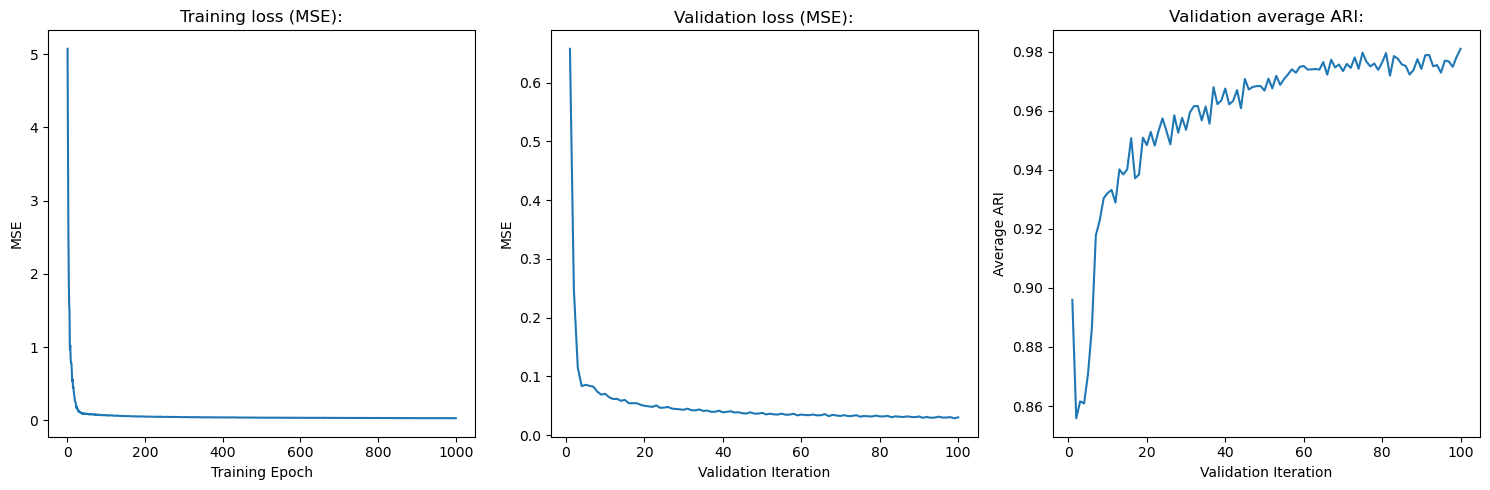

<Figure size 640x480 with 0 Axes>

In [10]:
# ============================================================
# Plot training curves:
# - Training MSE
# - Validation MSE
# - Validation ARI
# ============================================================

#display training metrics
train_epoch = [ep+1 for ep in range(epoch+1)]
val_epoch = [epoch+1 for epoch in range(len(validation_scores))]

fig, (col1, col2, col3) = plt.subplots(1, 3,figsize=(15,5))
col1.set_title("Training loss (MSE):")
col1.set_xlabel("Training Epoch")
col1.set_ylabel("MSE")
col2.set_title("Validation loss (MSE):")
col2.set_xlabel("Validation Iteration")
col2.set_ylabel("MSE")
col3.set_title("Validation average ARI:")
col3.set_xlabel("Validation Iteration")
col3.set_ylabel("Average ARI")
col1.plot(train_epoch,losses)
col2.plot(val_epoch,validation_losses)
col3.plot(val_epoch,validation_scores)
fig.tight_layout()
plt.show()
plt.clf()

<br><p style="font-size: 18px;"><b>Test set evaluation</b></p><br>
The following code evaluates the model on the test set:

In [11]:
# ============================================================
# Final evaluation on unseen test split.
# ARI measures segmentation consistency.
# ============================================================

model.eval()
with torch.no_grad():
    all_reconstructions, intermediate_outputs = model(testing_images.to(device))
    test_loss = model.get_loss(all_reconstructions,testing_images.to(device))
    test_average_ari = ari_score(testing_masks.to(device), intermediate_outputs[:,-1],num_objects)

print("Test set loss (MSE): "+str(test_loss.item()))
print("Test set score (ARI) :"+str(test_average_ari))

Test set loss (MSE): 0.03151119860096907
Test set score (ARI) :0.9760735412608632


<br><p style="font-size: 18px;"><b>Results of training and testing</b></p><br>
The numeric results show the training reduced MSE from its starting value of about 0.1618 to an ending value of about 0.0295. The training and validation curves are relatively smooth and have the sort of shapes one would hope for to indicate model learning. On the hold-out test set, the model achieved a MSE of about 0.0315 and an ARI score of about 0.9761. The ARI score was particularly good and was better than that reported by the paper. This may have been because the toy dataset was simpler than those used in the original paper. 

<br><p style="font-size: 18px;"><b>Demonstration 1</b></p><br>
The following illustrates functionality of the trained model on four sample images from the test set. Each demonstration sample shows:<br>
<ul>
<li>The raw image</li>
<li>The ground truth mask</li>
<li>The reconstructed image</li>
<li>The model's phase outputs</li>
<li>The clustered phase outputs</li>
</ul>
<br>

Demo 1 sample 1:


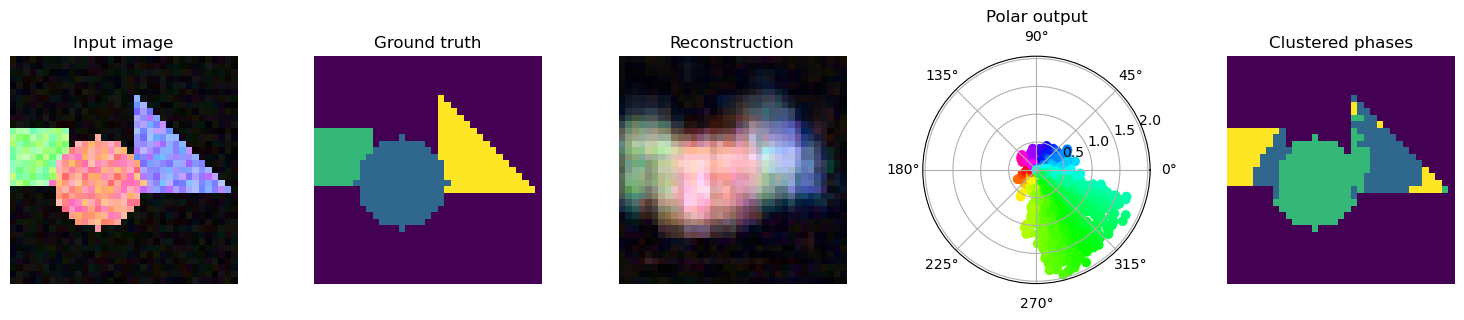


Demo 1 sample 2:


<Figure size 640x480 with 0 Axes>

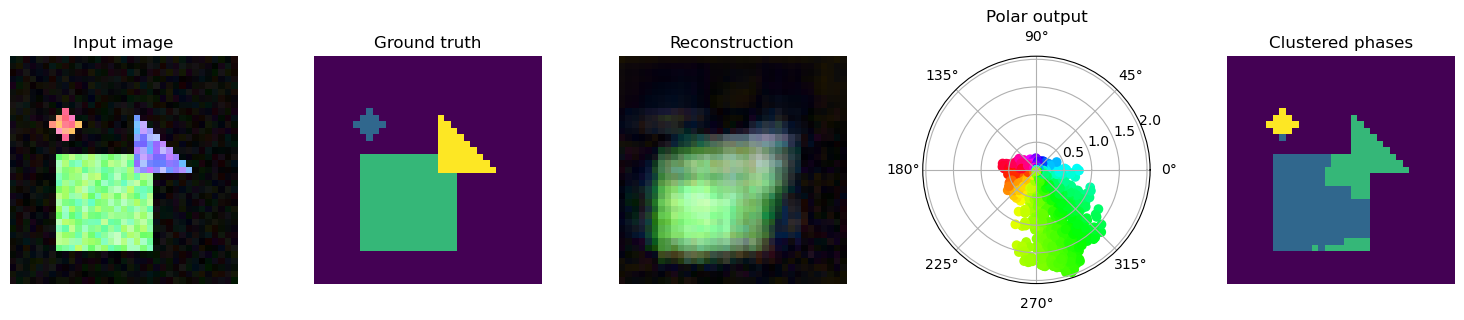


Demo 1 sample 3:


<Figure size 640x480 with 0 Axes>

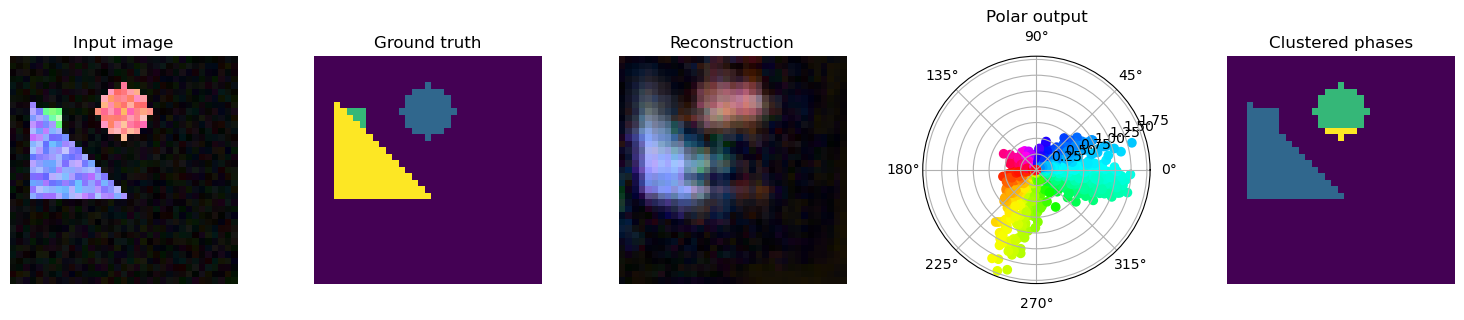


Demo 1 sample 4:


<Figure size 640x480 with 0 Axes>

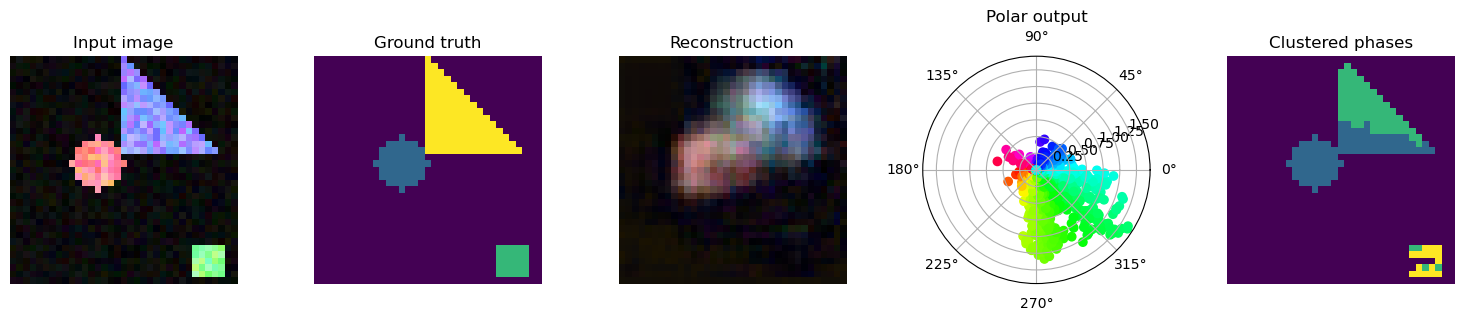

<Figure size 640x480 with 0 Axes>

In [12]:
# ============================================================
# Demo #1:
# - Show reconstruction for first 4 test samples
# - Display phase clustering + polar plots
# ============================================================

demo1_samples = 4
with torch.no_grad():
    all_reconstructions, intermediate_outputs = model(testing_images[:demo1_samples].to(device))
    clustered_reconstructions = cluster(intermediate_outputs[:,-1],num_objects,testing_masks[:demo1_samples].to(device))
    for i in range(demo1_samples):
        print("Demo 1 sample "+str(i+1)+":")
        reconstruction = all_reconstructions[i][-1].abs()
        reconstruction = torch.moveaxis(reconstruction,0,2).cpu().numpy()
        reconstruction = np.clip(reconstruction,0,1)
        image = testing_images[:demo1_samples][i]
        image = torch.moveaxis(image,0,2).cpu().numpy()
        visualize(image,clustered_reconstructions[i],reconstruction,testing_masks[i][0],intermediate_outputs[:,-1][i][-1])
        print()

<br><p style="font-size: 18px;"><b>Demonstration 2</b></p><br>
The following illustrates how the model's phase outputs evolve over each of the n recurrent iterations on two sample images from the test set.<br>

Demo 2 sample 1:


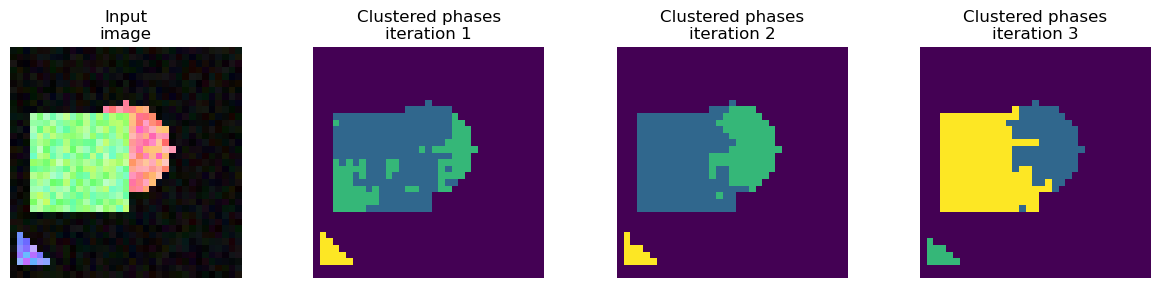


Demo 2 sample 2:


<Figure size 640x480 with 0 Axes>

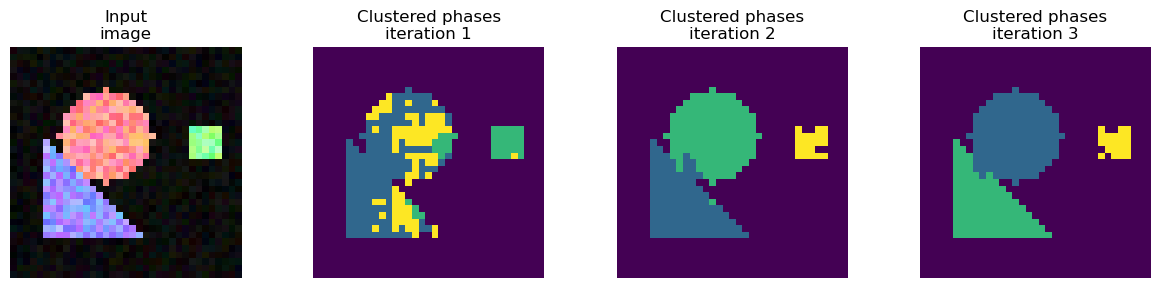

<Figure size 640x480 with 0 Axes>

In [13]:
# ============================================================
# Demo #2:
# - Show clustering evolution across recurrent iterations
# - Helps visualize how phase changes over iterations
# ============================================================

demo2_samples = 2
with torch.no_grad():
    demo2_images = testing_images[demo1_samples:demo1_samples+demo2_samples].to(device)
    demo2_masks = testing_masks[demo1_samples:demo1_samples+demo2_samples].to(device)
    all_reconstructions, intermediate_outputs = model(demo2_images)


    for i in range(demo2_samples):
        print("Demo 2 sample "+str(i+1)+":")
        repeated_mask = demo2_masks[i].repeat(n_iterations,1,1)
        clustered_reconstructions = cluster(intermediate_outputs[i],num_objects,repeated_mask)

        image = demo2_images[i]
        image = torch.moveaxis(image,0,2).cpu().numpy()

        fig = plt.figure(figsize=(15, 3))
        n = 100 + 10*(n_iterations+1)
        col1 = fig.add_subplot(n+1)
        col1.axis("off")
        col1.set_title("Input\nimage")
        col1.imshow(image)

        for i in range(n_iterations):
            col = fig.add_subplot(n+i+2)
            col.axis("off")
            col.set_title("Clustered phases\niteration "+str(i+1))
            col.imshow(clustered_reconstructions[i])

        plt.show()
        plt.clf()

        print()

<br><p style="font-size: 24px;"><b>Discussion</b></p>
As can be seen from the demonstrations, the model was far from perfect. It could have likely benefited from more epochs and hidden units. It appears based on the demonstration images that the model struggles when objects occlude one another or are touching. This can be seen in the first demonstration's third sample where the small square was significantly obstructed by the triangle - the model wound up treating the square as part of the triangle. Another case of this was the second demonstration's first image where the model got the depth ordering of the circle and the square reversed. It appears to struggle with the boundaries between objects. The best of the demonstration images appear to be those where the shapes are separated. The first demonstration's fourth image or the second demonstration's second image are examples of this. Also, all demonstration images except the first demonstration's third image has each object with a majority distinct color which is a good sign as can be interpreted as a measure of confidence in the distinctness of each object. The scaled-down model struggled with occlusion, though it should be noted that the larger model in the paper appeared to as well. The author's implementation had the best ARI on Tetronimoes where the objects do not overlap, while it did the worst on CLEVR where overlap is possible.  

Despite not being perfect, the results were promising with an excellent average ARI score on the test set and relatively smooth training and validation ARI and MSE curves. The image reconstructions were not very good, but this was somewhat expected given the low epoch count and scaled-down size. Additionally, image reconstruction was not the point of the model - the point was to obtain object bindings from phase output. The demonstration polar plots of the phase output were not great either - they appear worse than their corresponding phase clustering would suggest. The ideal polar plots would have shown four well-separated columnar formations of points each corresponding to a distinct object plus one for the background. That is because object bindings are obtained by phase alignment/synchrony so each of the four ideally distinct columns would represent a group of aligned phases.

There are multiple avenues for future work based on this model. It would be interesting to see what would happen if the number of feature maps were reduced in the encoder rather than increased. The authors chose a structure which expanded the number of feature maps in the middle, and it would be interesting to know what results the inverse structure would yield. Based not upon the scaled-down implementation, but upon the paper's parameters, it would be interesting to know what impact more layers and/or hidden units would have. It would also be interesting to know what effect different kernel sizes, strides, or even dilated convolution would have. Since the model struggled with occlusion, it would be interesting to know whether there are any preprocessing filters which could sharpen object contrast or otherwise help it distinguish nearby or visually overlapping objects. 

<br><p style="font-size: 18px;"><b>References</b></p>

Gopalakrishnan, Anand, Aleksandar Stanić, Jürgen Schmidhuber, and Michael Curtis Mozer.
2024. “Recurrent Complex-Weighted Autoencoders for Unsupervised Object Discovery.” In
Advances in Neural Information Processing Systems, edited by A. Globerson, L. Mackey, D.
Belgrave, A. Fan, U. Paquet, J. Tomczak, and C. Zhang, 37:140787–811. Curran Associates,
Inc. <a href="https://www.proceedings.com/079017-4468.html">https://doi.org/10.52202/079017-4468</a>. 